In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import parseTrackletXML as xmlParser
import os

label_dir = 'training/label_2/'
image_dir = 'training/image_2/'
calib_dir = 'training/calib/'



In [10]:
# Generating Demo Video of Training Images

predi_dir = 'training/box_3d/'

video_out = 'Video/kitti_3D.avi'
video_writer = None

# all_image = sorted(os.listdir(image_dir))
all_image = sorted(os.listdir(image_dir))[:30]
#np.random.shuffle(all_image)

for f in all_image:
    image_file = image_dir + f
    calib_file = calib_dir + f.replace('png', 'txt')
    predi_file = predi_dir + f.replace('png', 'txt')

    # read calibration data
    for line in open(calib_file):
        if 'P2:' in line:
            cam_to_img = line.strip().split(' ')
            cam_to_img = np.asarray([float(number) for number in cam_to_img[1:]])
            cam_to_img = np.reshape(cam_to_img, (3,4))
        
    image = cv2.imread(image_file)
    cars = []
    
    if video_writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        video_writer = cv2.VideoWriter(video_out, fourcc, 1.0, (1242, 375))

    # Draw 3D Bounding Box
    for line in open(predi_file):
        line = line.strip().split(' ')

        dims   = np.asarray([float(number) for number in line[8:11]])
        center = np.asarray([float(number) for number in line[11:14]])
        rot_y  = float(line[3]) + np.arctan(center[0]/center[2])#float(line[14])

        box_3d = []

        for i in [1,-1]:
            for j in [1,-1]:
                for k in [0,1]:
                    point = np.copy(center)
                    point[0] = center[0] + i * dims[1]/2 * np.cos(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.cos(-rot_y)
                    point[2] = center[2] + i * dims[1]/2 * np.sin(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.sin(-rot_y)                  
                    point[1] = center[1] - k * dims[0]

                    point = np.append(point, 1)
                    point = np.dot(cam_to_img, point)
                    point = point[:2]/point[2]
                    point = point.astype(np.int16)
                    box_3d.append(point)

        for i in range(4):
            point_1_ = box_3d[2*i]
            point_2_ = box_3d[2*i+1]
            cv2.line(image, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (0,255,0), 2)

        for i in range(8):
            point_1_ = box_3d[i]
            point_2_ = box_3d[(i+2)%8]
            cv2.line(image, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (0,255,0), 2)
                
    video_writer.write(np.uint8(image))

In [4]:
#Test Data Preperation

label_dir = 'testing2/label/'
image_dir = 'testing2/images_2/'
calib_dir = 'testing2/calib/'


# FIGURE OUT THE LABELS
os.system('rm ' + label_dir + '*')
os.system('rm ' + calib_dir + '*')

# Read transformation matrices
for line in open('calib_velo_to_cam.txt'):
    if 'R:' in line:
        R = line.strip().split(' ')
        R = np.asarray([float(number) for number in R[1:]])
        R = np.reshape(R, (3,3))
        
    if 'T:' in line:
        T = line.strip().split(' ')
        T = np.asarray([float(number) for number in T[1:]])
        T = np.reshape(T, (3,1))
        
for line in open('calib_cam_to_cam.txt'):
    if 'R_rect_00:' in line:
        R0_rect = line.strip().split(' ')
        R0_rect = np.asarray([float(number) for number in R0_rect[1:]])
        R0_rect = np.reshape(R0_rect, (3,3))

R0_rect = np.append(R0_rect, np.zeros((3,1)), axis=1)
R0_rect = np.append(R0_rect, np.zeros((1,4)), axis=0)
R0_rect[-1,-1] = 1

Tr_velo_to_cam = np.concatenate([R,T],axis=1)
Tr_velo_to_cam = np.append(Tr_velo_to_cam, np.zeros((1,4)), axis=0)
Tr_velo_to_cam[-1,-1] = 1

transform = np.dot(R0_rect, Tr_velo_to_cam)

#print Tr_velo_to_cam
#print R0_rect
#print transform

# Read the tracklets
for trackletObj in xmlParser.parseXML('tracklet_labels.xml'):
    for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in trackletObj:
        # label_file = label_dir + str(absoluteFrameNumber).zfill(10) + '.txt'
        label_file = label_dir + str(absoluteFrameNumber).zfill(10) + '.txt'
        
        translation = np.append(translation, 1)
        translation = np.dot(transform, translation)
        translation = translation[:3]/translation[3]
        
        with open(label_file, 'a') as file_writer:
            # line = [trackletObj.objectType] + [0,0,rotation[2]] + [0,0,0,0] + list(trackletObj.size) + list(translation) + [rotation[2]]
            line = [trackletObj.objectType] + [0,0,rotation[2]] + list(trackletObj.size) + list(translation) + [rotation[2]]
            line = ' '.join([str(item) for item in line]) + '\n'
            file_writer.write(line)

            
# FIGURE OUT THE CALIBRATION
for line in open('calib_cam_to_cam.txt'):
    if 'P_rect_02' in line:
        line_P2 = line.replace('P_rect_02', 'P2')
        print(line_P2)
        
for image in os.listdir(image_dir):
    label_file = label_dir + image.split('.')[0] + '.txt'
    calib_file = calib_dir + image.split('.')[0] + '.txt'
    
    # Create calib files
    with open(calib_file, 'w') as file_writer:
        file_writer.write(line_P2)
    
    # Fix missing lables
    with open(label_file, 'a') as file_writer:
        file_writer.write('')

        


Parsing tracklet file tracklet_labels.xml
File contains 98 tracklets
Loaded 98 tracklets.
P2: 7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01 0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01 0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03



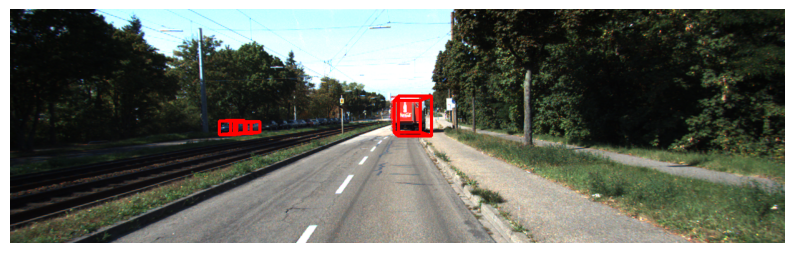

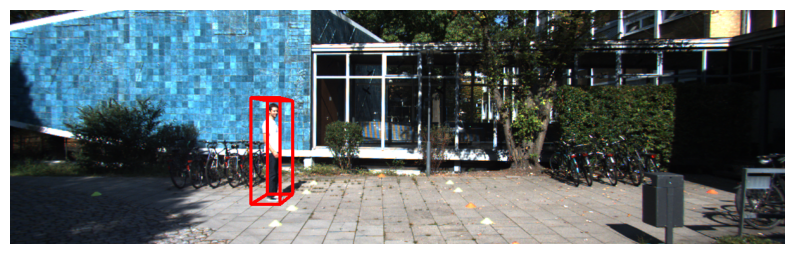

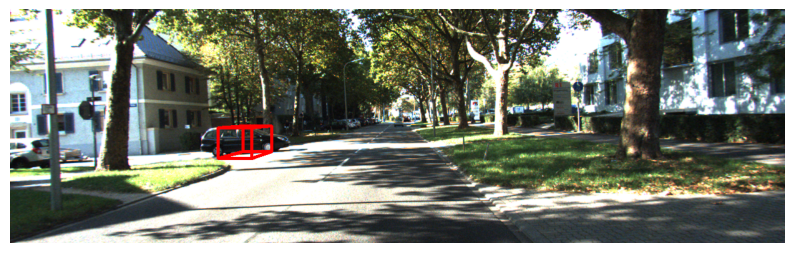

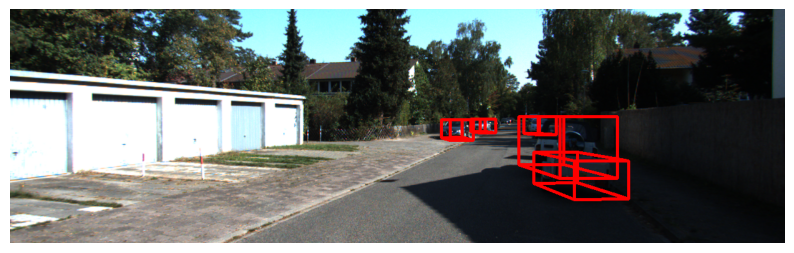

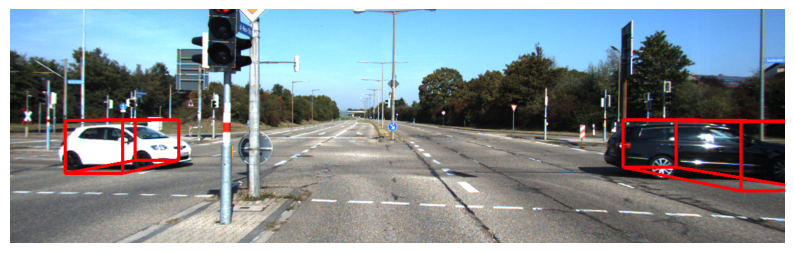

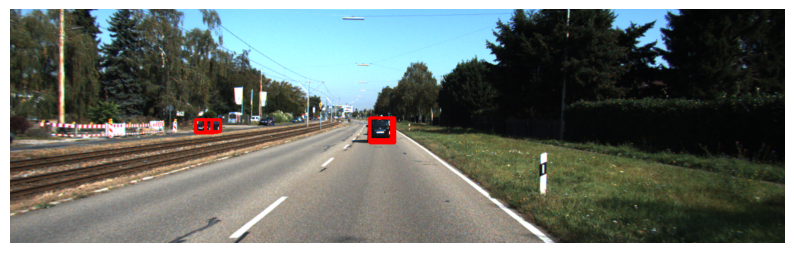

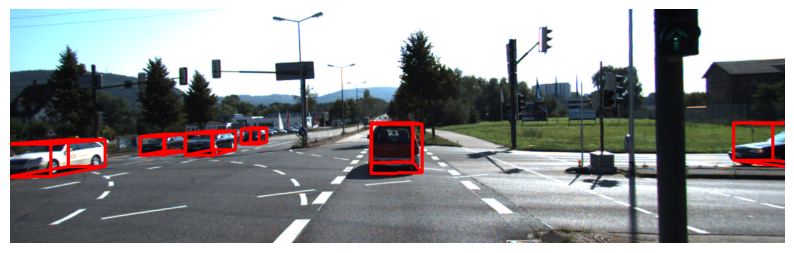

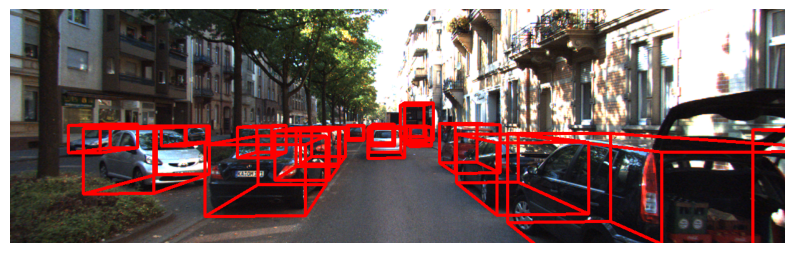

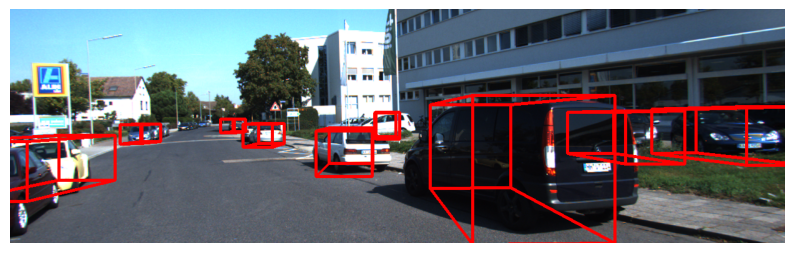

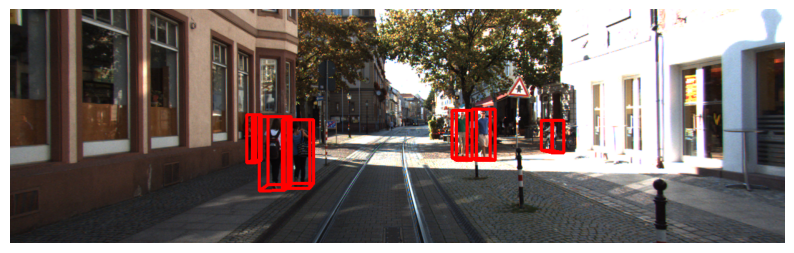

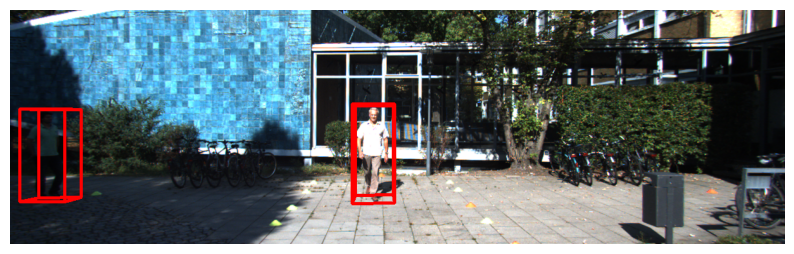

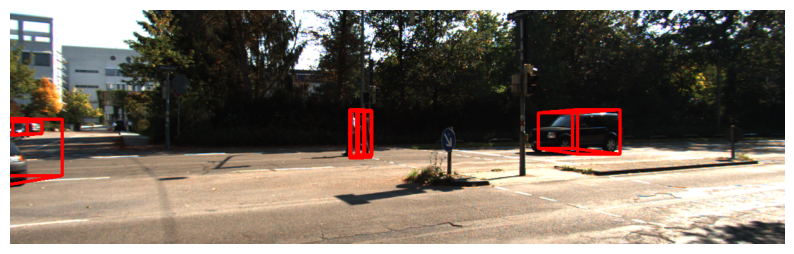

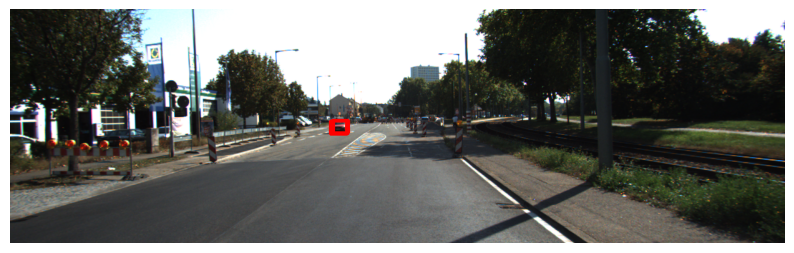

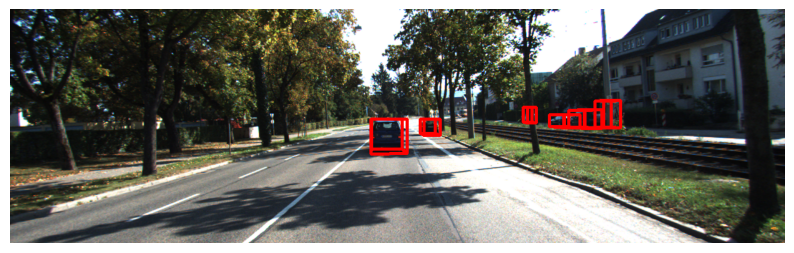

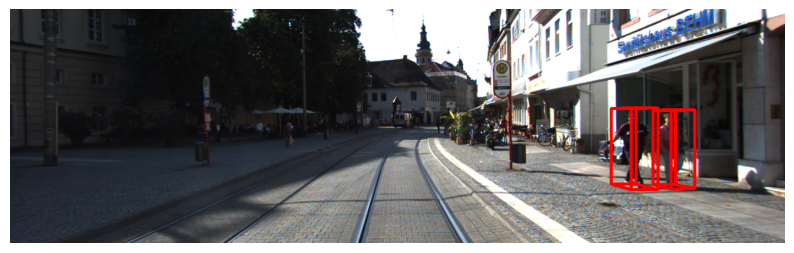

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define directories
image_dir = 'testing/image/'
box3d_loc = 'testing/bbox_3d/'
calib_dir = 'testing/calib/'

# Constants
NORM_H, NORM_W = 224, 224  # Normalized dimensions
dims_avg = {'Car': np.array([1.5, 1.7, 4.0])}  # Average dimensions for the "Car" class

# Helper functions
def compute_box_3d(dims, location, rotation_y):
    """Compute 3D bounding box corners."""
    h, w, l = dims
    x, y, z = location

    # Define 3D bounding box corners in object coordinates
    corners = np.array([
        [l / 2, 0, w / 2],
        [l / 2, 0, -w / 2],
        [-l / 2, 0, -w / 2],
        [-l / 2, 0, w / 2],
        [l / 2, -h, w / 2],
        [l / 2, -h, -w / 2],
        [-l / 2, -h, -w / 2],
        [-l / 2, -h, w / 2],
    ])

    # Apply rotation around Y-axis
    rotation_matrix = np.array([
        [np.cos(rotation_y), 0, np.sin(rotation_y)],
        [0, 1, 0],
        [-np.sin(rotation_y), 0, np.cos(rotation_y)],
    ])
    corners = np.dot(corners, rotation_matrix.T)

    # Translate the corners to the object's location
    corners += np.array([x, y, z])
    return corners

def project_to_image(corners_3d, proj_matrix):
    """Project 3D corners into 2D image space."""
    num_corners = corners_3d.shape[0]
    corners_3d_hom = np.hstack((corners_3d, np.ones((num_corners, 1))))
    corners_2d_hom = np.dot(proj_matrix, corners_3d_hom.T).T
    corners_2d = corners_2d_hom[:, :2] / corners_2d_hom[:, 2:]
    return corners_2d

def read_calibration_file(calib_file):
    """Read calibration file and extract projection matrix P2."""
    with open(calib_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        if line.startswith('P2:'):
            P2 = np.array(line.split()[1:], dtype=np.float32).reshape(3, 4)
            return P2
    raise ValueError(f"P2 matrix not found in {calib_file}")

# Iterate through the images
all_image = sorted(os.listdir(image_dir))[:15]  # Process only the first 15 images
for f in all_image:
    image_file = image_dir + f
    box3d_file = box3d_loc + f.replace('png', 'txt')
    calib_file = calib_dir + f.replace('png', 'txt')

    # Read the calibration matrix
    try:
        proj_matrix = read_calibration_file(calib_file)
    except ValueError as e:
        print(e)
        continue

    # Read the image
    img = cv2.imread(image_file)
    img = img.astype(np.uint8, copy=False)

    # Read the 3D bounding box file and project each box
    if not os.path.exists(box3d_file):
        print(f"Missing 3D bounding box file: {box3d_file}")
        continue

    with open(box3d_file, 'r') as box3d:
        for line in box3d:
            line = line.strip().split(' ')
            rotation_y = float(line[3])

            # 3D bounding box properties
            dims = np.array([float(line[8]), float(line[9]), float(line[10])])  # h, w, l
            location = np.array([float(line[11]), float(line[12]), float(line[13])])  # x, y, z

            # Compute 3D bounding box corners and project to 2D
            corners_3d = compute_box_3d(dims, location, rotation_y)
            corners_2d = project_to_image(corners_3d, proj_matrix)

            # Draw the 3D bounding box with red color and thicker lines
            for i in range(4):
                # Bottom rectangle
                cv2.line(img, tuple(corners_2d[i].astype(int)), tuple(corners_2d[(i + 1) % 4].astype(int)), (0, 0, 255), 3)
                # Top rectangle
                cv2.line(img, tuple(corners_2d[i + 4].astype(int)), tuple(corners_2d[(i + 1) % 4 + 4].astype(int)), (0, 0, 255), 3)
                # Vertical lines
                cv2.line(img, tuple(corners_2d[i].astype(int)), tuple(corners_2d[i + 4].astype(int)), (0, 0, 255), 3)

    # Display the image with 3D bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    plt.axis("off")
    plt.show()


In [6]:
# Generating Demo Video of Testing Images

predi_dir = 'testing/bbox_3d/'
image_dir = 'testing/image/'
calib_dir = 'testing/calib/'
video_out = 'PredictionVideo/output.avi'
video_writer = None

# Select the first 25 images
all_image = sorted(os.listdir(image_dir))[:30]

for f in all_image:
    image_file = image_dir + f
    calib_file = calib_dir + f.replace('png', 'txt')
    predi_file = predi_dir + f.replace('png', 'txt')

    # Read calibration data
    for line in open(calib_file):
        if 'P2:' in line:
            cam_to_img = line.strip().split(' ')
            cam_to_img = np.asarray([float(number) for number in cam_to_img[1:]])
            cam_to_img = np.reshape(cam_to_img, (3, 4))
        
    image = cv2.imread(image_file)
    
    if video_writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        video_writer = cv2.VideoWriter(video_out, fourcc, 1.0, (1242, 375))

    # Draw 3D Bounding Box
    for line in open(predi_file):
        line = line.strip().split(' ')

        dims = np.asarray([float(number) for number in line[8:11]])  # h, w, l
        center = np.asarray([float(number) for number in line[11:14]])  # x, y, z
        rot_y = float(line[3]) + np.arctan(center[0] / center[2])  # rotation_y

        box_3d = []

        for i in [1, -1]:
            for j in [1, -1]:
                for k in [0, 1]:
                    point = np.copy(center)
                    point[0] = center[0] + i * dims[1] / 2 * np.cos(-rot_y + np.pi / 2) + (j * i) * dims[2] / 2 * np.cos(-rot_y)
                    point[2] = center[2] + i * dims[1] / 2 * np.sin(-rot_y + np.pi / 2) + (j * i) * dims[2] / 2 * np.sin(-rot_y)                  
                    point[1] = center[1] - k * dims[0]

                    point = np.append(point, 1)
                    point = np.dot(cam_to_img, point)
                    point = point[:2] / point[2]
                    point = point.astype(np.int16)
                    box_3d.append(point)

        # Draw lines for the 3D bounding box
        for i in range(4):
            point_1_ = box_3d[2 * i]
            point_2_ = box_3d[2 * i + 1]
            cv2.line(image, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (0, 0, 255), 3)  # Red, thickness 3

        for i in range(8):
            point_1_ = box_3d[i]
            point_2_ = box_3d[(i + 2) % 8]
            cv2.line(image, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (0, 0, 255), 3)  # Red, thickness 3
                
    video_writer.write(np.uint8(image))

# Release the video writer
if video_writer is not None:
    video_writer.release()
    print(f"Video saved at {video_out}")


Video saved at PredictionVideo/output.avi
